In [1]:
%matplotlib inline


# Precipitation downscaling with RainFARM

This example script shows how to use the stochastic downscaling method RainFARM
available in pysteps.

RainFARM is a downscaling algorithm for rainfall fields developed by Rebora et
al. (2006). The method can represent the realistic small-scale variability of the
downscaled precipitation field by means of Gaussian random fields.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pprint import pprint

from pysteps import io, rcparams
from pysteps.utils import aggregate_fields_space, square_domain, to_rainrate
from pysteps.downscaling import rainfarm
from pysteps.visualization import plot_precip_field

Pysteps configuration file found at: /home/runner/.pysteps/pystepsrc



## Read the input data

As first step, we need to import the precipitation field that we are going
to use in this example.



{'accutime': 5.0,
 'cartesian_unit': 'm',
 'institution': 'MeteoSwiss',
 'orig_domain': (640, 710),
 'product': 'AQC',
 'projection': '+proj=somerc  +lon_0=7.43958333333333 +lat_0=46.9524055555556 '
               '+k_0=1 +x_0=600000 +y_0=200000 +ellps=bessel '
               '+towgs84=674.374,15.056,405.346,0,0,0,0 +units=m +no_defs',
 'square_method': 'crop',
 'threshold': 0.01155375598376629,
 'transform': None,
 'unit': 'mm/h',
 'x1': 290000.0,
 'x2': 930000.0,
 'xpixelsize': 1000.0,
 'y1': -160000.0,
 'y2': 480000.0,
 'yorigin': 'upper',
 'ypixelsize': 1000.0,
 'zerovalue': 0.0,
 'zr_a': 316.0,
 'zr_b': 1.5}


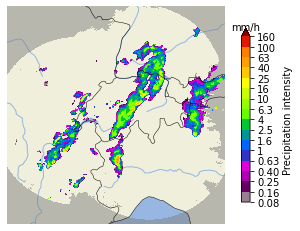

In [3]:
# Import the example radar composite
root_path = rcparams.data_sources["mch"]["root_path"]
filename = os.path.join(root_path, "20160711", "AQC161932100V_00005.801.gif")
precip, _, metadata = io.import_mch_gif(
    filename, product="AQC", unit="mm", accutime=5.0
)

# Convert to mm/h
precip, metadata = to_rainrate(precip, metadata)

# Reduce to a square domain
precip, metadata = square_domain(precip, metadata, "crop")

# Nicely print the metadata
pprint(metadata)

# Plot the original rainfall field
plot_precip_field(precip, geodata=metadata)
plt.show()

# Assign the fill value to all the Nans
precip[~np.isfinite(precip)] = metadata["zerovalue"]

## Upscale the field

To test our downscaling method, we first need to upscale the original field to
a lower resolution. We are going to use an upscaling factor of 16 x.



<GeoAxesSubplot:>

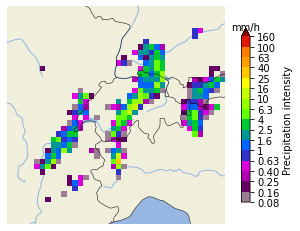

In [4]:
upscaling_factor = 16
upscale_to = metadata["xpixelsize"] * upscaling_factor  # upscaling factor : 16 x
precip_lr, metadata_lr = aggregate_fields_space(precip, metadata, upscale_to)

# Plot the upscaled rainfall field
plt.figure()
plot_precip_field(precip_lr, geodata=metadata_lr)

## Downscale the field

We can now use RainFARM to generate stochastic realizations of the downscaled
precipitation field.



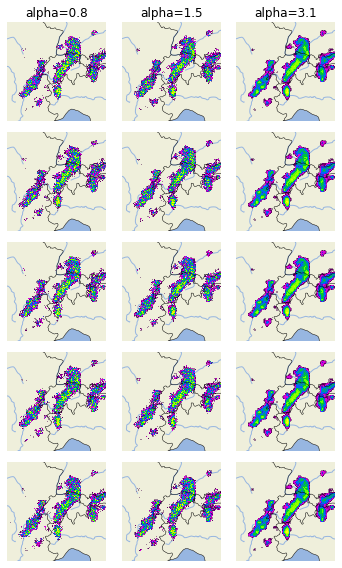

In [5]:
fig = plt.figure(figsize=(5, 8))
# Set the number of stochastic realizations
num_realizations = 5

# Per realization, generate a stochastically downscaled precipitation field
# and plot it.
# The first time, the spectral slope alpha needs to be estimated. To illustrate
# the sensitity of this parameter, we are going to plot some realizations with
# half or double the estimated slope.
alpha = None
for n in range(num_realizations):

    # Spectral slope estimated from the upscaled field
    precip_hr, alpha = rainfarm.downscale(
        precip_lr, alpha=alpha, ds_factor=upscaling_factor, return_alpha=True
    )
    plt.subplot(num_realizations, 3, n * 3 + 2)
    plot_precip_field(precip_hr, geodata=metadata, axis="off", colorbar=False)
    if n == 0:
        plt.title(f"alpha={alpha:.1f}")

    # Half the estimated slope
    precip_hr = rainfarm.downscale(
        precip_lr, alpha=alpha * 0.5, ds_factor=upscaling_factor
    )
    plt.subplot(num_realizations, 3, n * 3 + 1)
    plot_precip_field(precip_hr, geodata=metadata, axis="off", colorbar=False)
    if n == 0:
        plt.title(f"alpha={alpha * 0.5:.1f}")

    # Double the estimated slope
    precip_hr = rainfarm.downscale(
        precip_lr, alpha=alpha * 2, ds_factor=upscaling_factor
    )
    plt.subplot(num_realizations, 3, n * 3 + 3)
    plot_precip_field(precip_hr, geodata=metadata, axis="off", colorbar=False)
    if n == 0:
        plt.title(f"alpha={alpha * 2:.1f}")

    plt.subplots_adjust(wspace=0, hspace=0)

plt.tight_layout()
plt.show()

## Remarks

Currently, the pysteps implementation of RainFARM only covers spatial downscaling.
That is, it can improve the spatial resolution of a rainfall field. However, unlike
the original algorithm from Rebora et al. (2006), it cannot downscale the temporal
dimension.



## References

Rebora, N., L. Ferraris, J. von Hardenberg, and A. Provenzale, 2006: RainFARM:
Rainfall downscaling by a filtered autoregressive model. J. Hydrometeor., 7,
724–738.



In [6]:
# sphinx_gallery_thumbnail_number = 2